[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alessandronascimento/BioMolComp/blob/main/P10/ML.ipynb)

# Métodos de Aprendizado Supervisionado #

Nesta prática vamos tentar prever a estrutura do operon em bactérias. Um operon é um conjunto de genes adjacentes na mesma fita de DNA que são transcritos em uma única molécula de mRNA. A tradução da única molécula de mRNA produz as proteínas individuais. Para *Bacillus subtilis*, cujos dados usaremos, o número médio de genes em um operon é de cerca de 2,4.


Como primeiro passo para entender a regulação genética em bactérias, precisamos conhecer a estrutura do operon. Para cerca de 10% dos genes em *Bacillus subtilis*, a estrutura do operon é conhecida a partir de experimentos. Um método de aprendizado supervisionado pode ser usado para prever a estrutura do operon para os 90% restantes dos genes.


Para a abordagem de aprendizado supervisionado, precisamos escolher algumas variáveis ​​preditoras $x_i$ que podem ser medidas facilmente e estão de alguma forma relacionadas à estrutura do operon. Uma variável preditora pode ser a **distância em pares de bases entre os genes**. Genes adjacentes pertencentes ao mesmo operon tendem a ser separados por uma distância relativamente curta, enquanto genes adjacentes em diferentes operons tendem a ter um espaço maior entre eles para permitir sequências de promotor e terminador. 

Outra variável preditora é baseada em medidas de expressão gênica. Por definição, genes pertencentes ao mesmo operon têm perfis de expressão gênica iguais, enquanto genes em diferentes operons devem ter perfis de expressão diferentes. Na prática, os perfis de expressão medidos de genes no mesmo operon não são exatamente idênticos devido à presença de erros de medição. Para avaliar a semelhança nos perfis de expressão gênica, assumimos que os erros de medição seguem uma distribuição normal e calculamos a **pontuação de probabilidade logarítmica correspondente**.

Agora temos duas variáveis preditoras que podemos usar para prever se dois genes adjacentes na mesma fita de DNA pertencem ao mesmo operon:

*   $x_1$: o número de pares de bases entre eles;
*   $x_2$: sua semelhança no perfil de expressão.

Em um modelo de regressão logística, usamos uma soma ponderada desses dois preditores para calcular uma pontuação conjunta S:

$ S = \beta_0 + \beta_1 x_1 + \beta_2 x_2 $

O modelo de regressão logística nos fornece valores apropriados para os parâmetros β0, β1, β2 usando dois conjuntos de genes de exemplo:

*   OP: Genes adjacentes, na mesma fita de DNA, conhecidos por pertencerem ao mesmo operon;
*   NOP: Genes adjacentes, na mesma fita de DNA, conhecidos por pertencerem a diferentes operons.

No modelo de regressão logística, a probabilidade de pertencer a uma classe depende da pontuação por meio da função logística. Para as duas classes OP e NOP, podemos escrever isso como:

$ Pr(OP | x_1,x_2) = \frac{e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2}}{1+e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2}} $

$ Pr(NOP | x_1,x_2) = \frac{1}{1+e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2}} $

Usando um conjunto de pares de genes para os quais se sabe que pertencem ao mesmo operon (classe OP) ou a diferentes operons (classe NOP), podemos calcular os pesos β0, β1, β2 maximizando o l*og-likelihood* correspondente ao funções de probabilidade (equações acima).



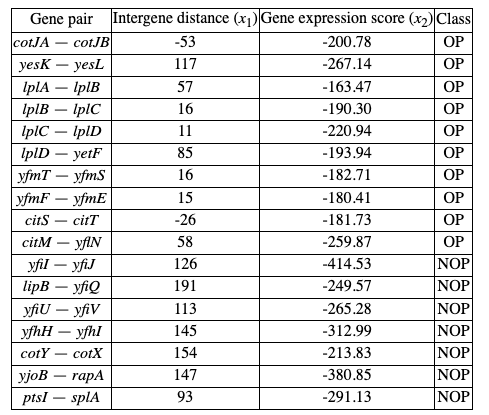

In [ ]:
!pip3 install biopython
def show_progress(iteration, loglikelihood):
        print("Iteration:", iteration, "Log-likelihood function:", loglikelihood)

In [ ]:
from Bio import LogisticRegression
xs = [[-53, -200.78],
[117, -267.14],
[57, -163.47],
[16, -190.30],
[11, -220.94],
[85, -193.94],
[16, -182.71],
[15, -180.41],
[-26, -181.73],
[58, -259.87],
[126, -414.53],
[191, -249.57],
[113, -265.28],
[145, -312.99],
[154, -213.83],
[147, -380.85],
[93, -291.13]]

ys = [1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
0,
0,
0,
0,
0,
0,
0]

model = LogisticRegression.train(xs, ys, update_fn=show_progress)

## Usando o Modelo de Regressão Logística Para Classificação ##

A classificação é realizada chamando a função *classify*. Dado um modelo de regressão logística e os valores para $x_1$ e $x_2$ (por exemplo, para um par de genes de estrutura de operon desconhecida), a função de classificação retorna 1 ou 0, correspondendo à classe OP e classe NOP, respectivamente. Por exemplo, vamos considerar os pares de genes yxcE, yxcD e yxiB, yxiA:

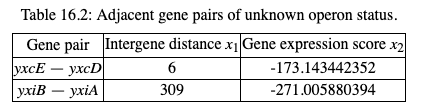

In [ ]:
print("yxcE, yxcD:", LogisticRegression.classify(model, [6, -173.143442352]))

print("yxiB, yxiA:", LogisticRegression.classify(model, [309, -271.005880394]))


o que, aliás, concorda com a literatura biológica.

Para descobrir o quão confiantes podemos estar nessas previsões, podemos chamar a função *calculate* para obter as probabilidades para as classes OP e NOP. 


Para yxcE, yxcD encontramos:

In [ ]:
q, p = LogisticRegression.calculate(model, [6, -173.143442352])
print("class OP: probability =", p, "class NOP: probability =", q)

e para os genes yxiB, yxiA:

In [ ]:
q, p = LogisticRegression.calculate(model, [309, -271.005880394])
print("class OP: probability =", p, "class NOP: probability =", q)

Para ter uma ideia da precisão da previsão do modelo de regressão logística, podemos aplicá-lo aos dados de treinamento:

In [ ]:
for i in range(len(ys)):
  print("True:", ys[i], "Predicted:", LogisticRegression.classify(model, xs[i]))

mostrando que a previsão está correta para todos, exceto um dos pares de genes. Uma estimativa mais confiável da precisão da previsão pode ser encontrada a partir de uma análise *leave-one-out*, na qual o modelo é recalculado a partir dos dados de treinamento após a remoção do gene a ser previsto:

In [ ]:
for i in range(len(ys)):
  model = LogisticRegression.train(xs[:i]+xs[i+1:], ys[:i]+ys[i+1:])
  print("True:", ys[i], "Predicted:", LogisticRegression.classify(model, xs[i]))

## Usando o Classificador de *k*-Vizinhos Mais Próximos ##

O método dos *k*-vizinhos mais próximos é uma abordagem de aprendizado supervisionado que não precisa ajustar um modelo aos dados. Em vez disso, os pontos de dados são classificados com base nas categorias dos *k* vizinhos mais próximos no conjunto de dados de treinamento.

Usando os dados da Tabela acima, criamos e inicializamos um modelo de k-vizinhos mais próximos da seguinte forma:

In [8]:
from Bio import kNN
k = 3
model = kNN.train(xs, ys, k)

onde *xs* e *ys* são os mesmos da seção anterior. Aqui, *k* é o número de vizinhos *k* que serão considerados para a classificação. Para classificação em duas classes, escolher um número ímpar para *k* permite evitar votos empatados.

O nome da função *train* é um pouco impróprio, já que nenhum treinamento de modelo é feito: esta função simplesmente armazena *xs*, *ys* e *k* em *model*.

Para classificar novos dados usando o modelo de *k*-vizinhos mais próximos, usamos a função classificar. Esta função pega um ponto de dados ($x_1,x_2$) e encontra os $k$ vizinhos mais próximos no conjunto de dados de treinamento *xs*. O ponto de dados ($x_1, x_2$) é então classificado com base em qual categoria (*ys*) ocorre mais entre os $k$ vizinhos.

Para o exemplo dos pares de genes yxcE, yxcD e yxiB, yxiA, encontramos:

In [ ]:
x = [6, -173.143442352]
print("yxcE, yxcD:", kNN.classify(model, x))

x = [309, -271.005880394]
print("yxiB, yxiA:", kNN.classify(model, x))


De acordo com o modelo de regressão logística, yxcE, yxcD são classificados como pertencentes ao mesmo operon (classe OP), enquanto yxiB, yxiA são previstos como pertencentes a diferentes operons.

Para ter uma ideia da precisão da previsão da abordagem de $k$-vizinhos mais próximos, podemos aplicá-la aos dados de treinamento:

In [ ]:
for i in range(len(ys)):
  print("True:", ys[i], "Predicted:", kNN.classify(model, xs[i]))

mostrando que a previsão está correta para todos, exceto dois dos pares de genes. Uma estimativa mais confiável da precisão da previsão pode ser encontrada a partir de uma análise leave-one-out, na qual o modelo é recalculado a partir dos dados de treinamento após a remoção do gene a ser previsto:

In [ ]:
k = 3
for i in range(len(ys)):
  model = kNN.train(xs[:i]+xs[i+1:], ys[:i]+ys[i+1:], k)
  print("True:", ys[i], "Predicted:", kNN.classify(model, xs[i]))